In [9]:
#Import Library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator #type: ignore
from tensorflow.keras.applications import MobileNetV2 #type: ignore
from tensorflow.keras.models import Sequential #type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout #type: ignore
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input #type: ignore
import json
import os

In [10]:
# Konfig
DATASET_PATH = 'dataset/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10 

#Augmentasi
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'train/'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(DATASET_PATH, 'val/'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 185 images belonging to 2 classes.
Found 44 images belonging to 2 classes.


In [11]:
# Arsitektur Model 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,914,882 (11.12 MB)

 Trainable params: 656,898 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
#train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS
).history

c:\Users\abrar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 697ms/step - accuracy: 0.5521 - loss: 0.8874 - val_accuracy: 1.0000 - val_loss: 0.0483
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9062 - loss: 0.2096

c:\Users\abrar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9062 - loss: 0.2096 - val_accuracy: 0.9062 - val_loss: 0.1468
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.9591 - loss: 0.2076 - val_accuracy: 1.0000 - val_loss: 0.0050
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.9688 - loss: 0.0608 - val_accuracy: 1.0000 - val_loss: 0.0039
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.9805 - loss: 0.0569 - val_accuracy: 1.0000 - val_loss: 0.0206
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.9375 - loss: 0.1299 - val_accuracy: 1.0000 - val_loss: 0.0128
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.9869 - loss: 0.0464 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9688 - loss: 0.0835 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.9837 - loss: 0.0354 - val_accuracy: 1.0000 - val_loss: 0.0066
Epoch 1

TypeError: 'History' object is not subscriptable

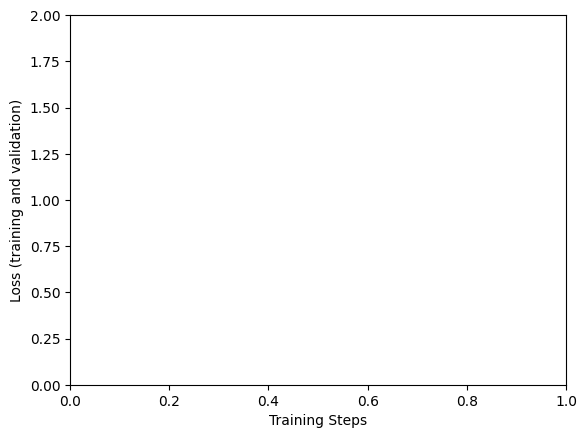

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [ ]:
# save model
model.save('model1.h5')
with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

print("Done disimpan")

In [ ]:
#Uji coba klasifikasi
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
import numpy as np
import json
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # type: ignore

#load model
MODEL_PATH = 'model1.h5'
loaded_model = load_model(MODEL_PATH)

with open('class_names.json', 'r') as f:
    class_names = json.load(f)

def predict_image(image_path):

    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    processed_img_array = preprocess_input(img_array) 

    predictions = loaded_model.predict(processed_img_array)
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_names[predicted_class_index]
    confidence = np.max(predictions[0]) * 100

    return predicted_class_name, confidence

#ujinya
TEST_IMAGE_PATH = 'path img' 

try:
    predicted_class, confidence_score = predict_image(TEST_IMAGE_PATH)
    print(f"Gambar: {TEST_IMAGE_PATH}")
    print(f"Hasil Prediksi: {predicted_class}")
    print(f"Confidence: {confidence_score:.2f}%")
except FileNotFoundError:
    print(f"File not found di {TEST_IMAGE_PATH}")
except NameError as e:
    print(f"error{e}")